# raincell

> A user-friendly Python library for transforming commercial microwave links into rain estimation insights. Built with nbdev and Jupyter notebooks, this tool offers robust scientific and visualization capabilities, tailored for researchers in the field.

> Tip: If you are reading this in the [GitHub's][repo] readme, we recommend consulting the much more nicely formatted [documentation][docs] instead.

[repo]: https://github.com/rainsmore/raincell
[docs]: https://rainsmore.github.io/raincell/

## Install

Install the latest version of the package from GitHub [repository][repo]:

```sh
$ pip install git+ssh://git@github.com/rainsmore/raincell.git
```

in the future we will also allow installing directly from conda and from pypi.

[repo]: https://github.com/rainsmore/raincell

<!--
or from [conda][conda] (not available yet)

```sh
$ conda install -c rainsmore raincell
```

or from [pypi][pypi] (not available yet)


```sh
$ pip install raincell
```

[pypi]: https://pypi.org/project/raincell/
[conda]: https://anaconda.org/rainsmore/raincell
-->

## Contributing

All help is welcome, so if you would like to contribute (bug reports, documentation, etc.), please check our contribution [guide](https://github.com/rainsmore/raincell/blob/main/CONTRIBUTING.md). This guide also explains our approach to notebook development.

## Getting started

If this is the first time you are using the Raincell library, we highly recommend following the tutorial in this section. You can either work through the online documentation or download this file as a notebook and work through it locally. The tutorial will guide you step by step through the process of converting raw Commercial Microwave Link (CML) data into precipitation rate estimates. 

:::{.callout-tip}
If you are already familiar with the library, you can skip to the [Next steps](#sec-next-steps) section. However, we recommend checking it from time to time, as new basic functionalities will appear here.
:::

In [ ]:
from raincell import open_cml_sample, open_gauge_sample

Lets start by opening commercial microwave link (CML) sample data over the city of Douala with 15 min and max sampling of the Network Management System (NMS).

In [ ]:
cml = open_cml_sample()
cml

<xarray.Dataset> Size: 108MB
Dimensions:      (cml_id: 126, sublink_id: 6, time: 2964)
Coordinates: (10)
Data variables:
    rsl_avg      (cml_id, sublink_id, time) float64 18MB -48.0 -48.0 ... nan nan
    tsl_avg      (cml_id, sublink_id, time) float64 18MB 10.0 10.0 ... nan nan
    rsl_min      (cml_id, sublink_id, time) float64 18MB -48.8 -48.3 ... nan nan
    tsl_min      (cml_id, sublink_id, time) float64 18MB 10.0 10.0 ... nan nan
    rsl_max      (cml_id, sublink_id, time) float64 18MB -47.6 -47.8 ... nan nan
    tsl_max      (cml_id, sublink_id, time) float64 18MB 10.0 10.0 ... nan nan
Attributes:
    title:                 East side Douala CML links sample data
    file author(s):        Orange Cameroun and IRD Rainsmore Group
    institution:           Orange Cameroun and IRD Rainsmore Group
    date:                  2025-11-07
    source:                Modified Orange Cameroun CML data for example purp...
    naming convention:     COST ACTION OPENSENSE V2
    license restrictions:  CC BY-NC-ND 4.0

We will also open gauges sample data for the same region and time period.

In [ ]:
gauge = open_gauge_sample()
gauge

<xarray.Dataset> Size: 393kB
Dimensions:                  (gauge_name: 8, time: 2881)
Coordinates: (6)
Data variables:
    tp                       (gauge_name, time) float64 184kB 0.0 0.0 ... 0.0
    tprate                   (gauge_name, time) float64 184kB 0.0 0.0 ... 0.0
Attributes:
    title:                 East side Douala Gauges sample data
    file author(s):        IUT de Douala  and IRD Rainsmore Group
    license restrictions:  CC BY-NC-ND 4.0

In order to retrieve the precipitation rate we need to classify the data as wet or dry.

In [ ]:
from raincell import wetdry

In [ ]:
wet = wetdry.schleiss_n_berne_2010_nms_adapted(cml)
wet

<xarray.DataArray 'wet' (cml_id: 126, sublink_id: 6, time: 2964)> Size: 2MB
False False False False False False ... False False False False False False
Coordinates: (10)
Attributes:
    long_name:  wet_dry_classification
    method:     schleiss_n_berne_2010_adapted_to_nms_min_max_sampling

Remember that if you are using and IDE such as jupyter or vscode you can type `wetdry.` and then press **tab** to get the available methods. You can also check the `Wet/Dry classification` section in the left bar of the [doc](https://rainsmore.github.io/raincell/) for further details.

Next we need to compute the attenuations. As we are using min and max sampling, and TSL doesn't vary a lot we will use minimum and maximum attenuations.

In [ ]:
att = (cml["tsl_min"] - cml["rsl_min"]).to_dataset(name="att_min")
att["att_max"] = cml["tsl_max"] - cml["rsl_max"]

Now that attenuation is ready, lets compute the baseline. During dry periods signal is stable so minimum and máximum attenuation should also be stable. For this reason we will take the average of both signals to compute the baseline.

In [ ]:
from raincell import baseline

In [ ]:
avg = (att["att_min"] + att["att_max"])/2
avg.name = ""
bl = baseline.get_bl_as_last_dry_step(avg, wet)
bl

<xarray.DataArray '' (cml_id: 126, sublink_id: 6, time: 2964)> Size: 18MB
58.2 58.05 58.1 58.2 58.15 58.1 58.05 58.05 ... nan nan nan nan nan nan nan nan
Coordinates: (10)
Attributes:
    long_name:  _baseline
    method:     get_bl_as_last_dry_step

By removing the baseline to the attenuations we can obtain the attenuation due to rain.

In [ ]:
att_rain = att - bl
att_rain

<xarray.Dataset> Size: 36MB
Dimensions:      (cml_id: 126, sublink_id: 6, time: 2964)
Coordinates: (10)
Data variables:
    att_min      (cml_id, sublink_id, time) float64 18MB 0.6 0.25 ... nan nan
    att_max      (cml_id, sublink_id, time) float64 18MB -0.6 -0.25 ... nan nan

Rain related attenuation has two components: Wet Antenna Attenuation (WAA) and Path Integrated Attenuation (PIA). We need to isolate the later to be able to estimate the percipitation rate.

In [ ]:
from raincell import waa

In [ ]:
pia = waa.rm_constant_waa(att_rain)
pia

<xarray.Dataset> Size: 36MB
Dimensions:      (cml_id: 126, sublink_id: 6, time: 2964)
Coordinates: (10)
Data variables:
    att_min      (cml_id, sublink_id, time) float64 18MB -1.7 -2.05 ... nan nan
    att_max      (cml_id, sublink_id, time) float64 18MB -2.9 -2.55 ... nan nan

Finally we can obtain the precipitation rate as follows.

In [ ]:
from raincell import rrate

In [ ]:
tprate = rrate.get_overeem_et_al_2013_min_max_nms_tprate(
    pia, rrate.alcoba_2019_africa_coefs(), name_min="att_min", name_max="att_max"
)
tprate

<xarray.Dataset> Size: 18MB
Dimensions:      (cml_id: 126, sublink_id: 6, time: 2964)
Coordinates: (10)
Data variables:
    tprate       (cml_id, sublink_id, time) float64 18MB 0.0 0.0 0.0 ... 0.0 0.0

Let's visually compare the estimated precipitation rates from the CML-based retrievals with the precipitation rates measured by the ground gauges.

In [ ]:
from raincell import plot

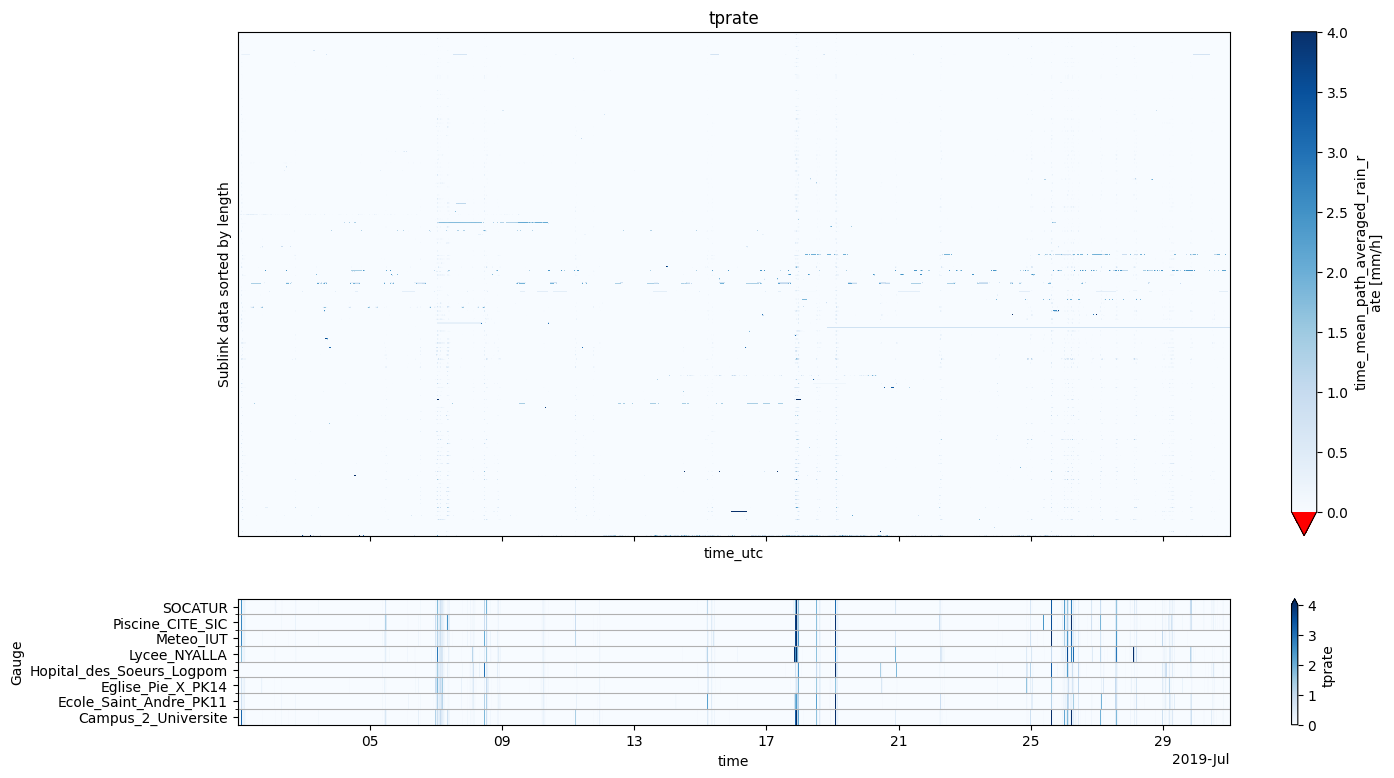

In [ ]:
plot.romulo_plot(tprate["tprate"], gauge["tprate"], cml_vmax=4, gauges_vmax=4);

## Next steps {#sec-next-steps}

Now that you are familiar with the library, you can start using it by importing the relevant functions. Alternatively, you can download any of the available notebooks to use as a starting point for analysing your own data. You can also explore the available methods, visualisations, etc. by reading through the documentation.